In [84]:
import re
import string
from joblib import dump, load

import numpy as np
import pandas as pd
import surprise
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from surprise import SVD, Reader, Dataset

In [2]:
movies = pd.read_csv('data/movies.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [3]:
ratings = pd.read_csv('data/ratings.csv')
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [4]:
movies_metadata = pd.read_csv('data/movies_metadata.csv')
movies_metadata

/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_4216/568110564.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv('data/movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [5]:
movies_metadata = movies_metadata.dropna(subset=['title'])
movies_metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [6]:
# remove the year from the title
movies['title_name'] = movies['title'].apply(lambda x: re.sub(r'\s\(\d{4}\)$', '', x))
movies

,movieId,title,genres,title_name
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,Black Butler: Book of the Atlantic
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,No Game No Life: Zero
9739,193585,Flint (2017),Drama,Flint
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple


In [7]:
movies_metadata[movies_metadata['title'].isin(movies['title_name'])]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45371,False,"{'id': 477208, 'name': 'DC Super Hero Girls Co...",0,"[{'id': 16, 'name': 'Animation'}]",NaN,460135,tt7158814,en,LEGO DC Super Hero Girls: Brain Drain,"When Supergirl, Wonder Woman, Batgirl, Bumbleb...",...,2017-08-30,0.0,0.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,LEGO DC Super Hero Girls: Brain Drain,False,10.0,2.0
45406,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,98604,tt2147597,ru,Zolushka,"Masha Krapivina - is yet beautiful, and not th...",...,2012-02-14,0.0,91.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Cinderella,False,4.6,6.0
45409,False,NaN,800000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45421,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10769, 'n...",NaN,52103,tt0144020,zh,Xiao Wu,Little pocket thief Wu never got away from the...,...,1997-01-01,0.0,105.0,"[{'iso_639_1': 'zh', 'name': '普通话'}]",Released,NaN,Pickpocket,False,7.2,13.0


In [8]:
movies[~movies['title_name'].isin(movies_metadata['title'])]

,movieId,title,genres,title_name
10,11,"American President, The (1995)",Comedy|Drama|Romance,"American President, The"
28,29,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,"City of Lost Children, The (Cité des enfants p..."
29,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime|Drama,Shanghai Triad (Yao a yao yao dao waipo qiao)
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,Twelve Monkeys (a.k.a. 12 Monkeys)
42,46,How to Make an American Quilt (1995),Drama|Romance,How to Make an American Quilt
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,Black Butler: Book of the Atlantic
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,No Game No Life: Zero
9739,193585,Flint (2017),Drama,Flint
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple


In [9]:
stopwords = ['the', 'a', 'an']

In [10]:
def clean_title(title):
    title = title.lower()
    title = title.translate(str.maketrans('', '', string.punctuation))
    return set([word for word in title.split() if word not in stopwords])

In [11]:
movies['title_name_tokens'] = movies['title_name'].apply(clean_title)
movies_metadata['title_name_tokens'] = movies_metadata['title'].apply(clean_title)

/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_4216/718884715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_metadata['title_name_tokens'] = movies_metadata['title'].apply(clean_title)


In [12]:
def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union


# def map_name(title_name_tokens):
#     # return the one with the highest jaccard similarity
#     title_jaccard = movies_metadata['title_name_tokens'].apply(jaccard_similarity, args=(title_name_tokens,))
#     return max(movies_metadata['title'],
#                key=lambda x: movies_metadata[movies_metadata['title'] == x]['title_jaccard'].values[0])

def map_name(title_name_tokens):
    max_similarity = -1
    max_title = None

    for _, row in movies_metadata.iterrows():
        similarity = jaccard_similarity(title_name_tokens, row['title_name_tokens'])
        if similarity > max_similarity:
            max_similarity = similarity
            max_title = row['title']

    return max_title

In [13]:
unmapped_movies = movies[~movies['title_name'].isin(movies_metadata['title'])]

In [14]:
def style(s, style):
    return style + s + '\033[0m'


def green(s):
    return style(s, '\033[92m')


def red(s):
    return style(s, '\033[91m')


def bold(s):
    return style(s, '\033[1m')

In [15]:
# movies_name_map = {}
# for name, tokens in unmapped_movies[['title_name', 'title_name_tokens']].values:
#     try:
#         res = map_name(tokens)
#         movies_name_map[name] = res
#
#         print(green(f'{name} -> {res}'))
#     except Exception as e:
#         print(bold(red(f'!!! ERROR !!! {e}')))
#         print(bold(red(f'!!! ERROR !!! {name}')))
#         print(bold(red(str(tokens))))
#         continue

In [16]:
movies['title_mapped'] = movies['title_name'].map(
    lambda x: movies_name_map.get(x, x) if x in unmapped_movies['title_name'].values else x)
movies

NameError: name 'movies_name_map' is not defined

In [ ]:
movies[movies['title_mapped'].notna()]

In [17]:
# movies.to_csv('data/movies_mapped.csv', index=False)

In [18]:
movies = pd.read_csv('data/movies_mapped.csv')
movies

,movieId,title,genres,title_name,title_name_tokens,title_mapped
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,"{'story', 'toy'}",Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,{'jumanji'},Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,"{'grumpier', 'men', 'old'}",Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,"{'to', 'exhale', 'waiting'}",Waiting to Exhale
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,"{'of', 'bride', 'ii', 'part', 'father'}",Father of the Bride Part II
...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,Black Butler: Book of the Atlantic,"{'of', 'butler', 'atlantic', 'black', 'book'}",Black Book
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,No Game No Life: Zero,"{'game', 'no', 'zero', 'life'}",The Game
9739,193585,Flint (2017),Drama,Flint,{'flint'},In Like Flint
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple,"{'apple', 'dead', 'dogs', 'bungo', 'stray'}",Stray Dogs


In [19]:
movies_metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,title_name_tokens
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"{story, toy}"
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,{jumanji}
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"{old, grumpier, men}"
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"{to, exhale, waiting}"
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"{bride, ii, father, part, of}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,{subdue}
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0,"{of, century, birthing}"
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,{betrayal}
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0,"{triumphant, satan}"


In [20]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [21]:
ratings[['movieId', 'rating']].groupby('movieId').mean()

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429
...,...
193581,4.000000
193583,3.500000
193585,3.500000


# EDA

## Analysis of the genres

In [22]:
movies['genres'].apply(lambda x: x.split('|')).explode().value_counts()

Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
Name: genres, dtype: int64

<Axes: >

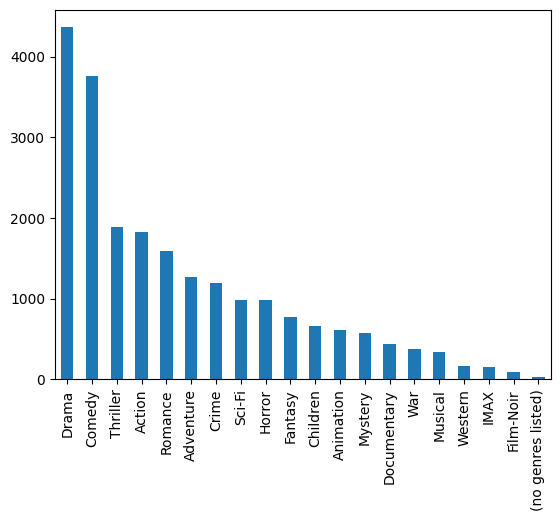

In [23]:
movies['genres'].apply(lambda x: x.split('|')).explode().value_counts().plot(kind='bar')

In [24]:
movies['genres'].apply(lambda x: x.split('|')).apply(len).max()

10

In [25]:
genres = movies['genres'].apply(lambda x: x.split('|')).explode().unique()
genres

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

In [26]:
for genre in genres:
    movies[genre] = movies['genres'].str.contains(genre).astype(int)
movies

/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_4216/3798288993.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  movies[genre] = movies['genres'].str.contains(genre).astype(int)


,movieId,title,genres,title_name,title_name_tokens,title_mapped,Adventure,Animation,Children,Comedy,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,"{'story', 'toy'}",Toy Story,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,{'jumanji'},Jumanji,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,"{'grumpier', 'men', 'old'}",Grumpier Old Men,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,"{'to', 'exhale', 'waiting'}",Waiting to Exhale,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,"{'of', 'bride', 'ii', 'part', 'father'}",Father of the Bride Part II,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,Black Butler: Book of the Atlantic,"{'of', 'butler', 'atlantic', 'black', 'book'}",Black Book,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,No Game No Life: Zero,"{'game', 'no', 'zero', 'life'}",The Game,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),Drama,Flint,{'flint'},In Like Flint,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple,"{'apple', 'dead', 'dogs', 'bungo', 'stray'}",Stray Dogs,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Add movies metadata

In [27]:
movies_metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,title_name_tokens
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"{story, toy}"
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,{jumanji}
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"{old, grumpier, men}"
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"{to, exhale, waiting}"
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"{bride, ii, father, part, of}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,{subdue}
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0,"{of, century, birthing}"
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,{betrayal}
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0,"{triumphant, satan}"


In [28]:
movies = movies.join(movies_metadata[
                         ['title', 'budget', 'overview', 'popularity', 'production_companies', 'revenue', 'runtime',
                          'vote_average', 'vote_count']].set_index('title'), on='title_mapped')
movies

,movieId,title,genres,title_name,title_name_tokens,title_mapped,Adventure,Animation,Children,Comedy,...,Film-Noir,(no genres listed),budget,overview,popularity,production_companies,revenue,runtime,vote_average,vote_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,"{'story', 'toy'}",Toy Story,1,1,1,1,...,0,0,30000000,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",373554033.0,81.0,7.7,5415.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,{'jumanji'},Jumanji,1,0,1,0,...,0,0,65000000,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",262797249.0,104.0,6.9,2413.0
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,"{'grumpier', 'men', 'old'}",Grumpier Old Men,0,0,0,1,...,0,0,0,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",0.0,101.0,6.5,92.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,"{'to', 'exhale', 'waiting'}",Waiting to Exhale,0,0,0,1,...,0,0,16000000,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,81452156.0,127.0,6.1,34.0
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,"{'of', 'bride', 'ii', 'part', 'father'}",Father of the Bride Part II,0,0,0,1,...,0,0,0,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",76578911.0,106.0,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,No Game No Life: Zero,"{'game', 'no', 'zero', 'life'}",The Game,0,1,0,1,...,0,0,50000000,"In honor of his birthday, San Francisco banker...",14.825587,"[{'name': 'PolyGram Filmed Entertainment', 'id...",109423648.0,129.0,7.5,1556.0
9739,193585,Flint (2017),Drama,Flint,{'flint'},In Like Flint,0,0,0,0,...,0,0,0,Flint is again called out of retirement when h...,2.433339,[],0.0,114.0,6.1,20.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple,"{'apple', 'dead', 'dogs', 'bungo', 'stray'}",Stray Dogs,0,1,0,0,...,0,0,0,Two children are orphaned in post-Taliban Afgh...,0.143835,"[{'name': 'Wild Bunch', 'id': 856}, {'name': '...",0.0,93.0,6.5,2.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple,"{'apple', 'dead', 'dogs', 'bungo', 'stray'}",Stray Dogs,0,1,0,0,...,0,0,0,A father and his two children wander the margi...,1.319475,"[{'name': 'Homegreen Films', 'id': 8041}, {'na...",0.0,138.0,7.1,19.0


In [29]:
movies['production_companies'].apply(eval).apply(len).explode().max()

26

In [30]:
movies['production_companies'] = movies['production_companies'].apply(eval)
movies

,movieId,title,genres,title_name,title_name_tokens,title_mapped,Adventure,Animation,Children,Comedy,...,Film-Noir,(no genres listed),budget,overview,popularity,production_companies,revenue,runtime,vote_average,vote_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,"{'story', 'toy'}",Toy Story,1,1,1,1,...,0,0,30000000,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",373554033.0,81.0,7.7,5415.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,{'jumanji'},Jumanji,1,0,1,0,...,0,0,65000000,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",262797249.0,104.0,6.9,2413.0
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,"{'grumpier', 'men', 'old'}",Grumpier Old Men,0,0,0,1,...,0,0,0,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",0.0,101.0,6.5,92.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,"{'to', 'exhale', 'waiting'}",Waiting to Exhale,0,0,0,1,...,0,0,16000000,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,81452156.0,127.0,6.1,34.0
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,"{'of', 'bride', 'ii', 'part', 'father'}",Father of the Bride Part II,0,0,0,1,...,0,0,0,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",76578911.0,106.0,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,No Game No Life: Zero,"{'game', 'no', 'zero', 'life'}",The Game,0,1,0,1,...,0,0,50000000,"In honor of his birthday, San Francisco banker...",14.825587,"[{'name': 'PolyGram Filmed Entertainment', 'id...",109423648.0,129.0,7.5,1556.0
9739,193585,Flint (2017),Drama,Flint,{'flint'},In Like Flint,0,0,0,0,...,0,0,0,Flint is again called out of retirement when h...,2.433339,[],0.0,114.0,6.1,20.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple,"{'apple', 'dead', 'dogs', 'bungo', 'stray'}",Stray Dogs,0,1,0,0,...,0,0,0,Two children are orphaned in post-Taliban Afgh...,0.143835,"[{'name': 'Wild Bunch', 'id': 856}, {'name': '...",0.0,93.0,6.5,2.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple,"{'apple', 'dead', 'dogs', 'bungo', 'stray'}",Stray Dogs,0,1,0,0,...,0,0,0,A father and his two children wander the margi...,1.319475,"[{'name': 'Homegreen Films', 'id': 8041}, {'na...",0.0,138.0,7.1,19.0


In [31]:
movies['production_companies'].apply(lambda x: [o['name'] for o in x]).explode().value_counts()

Warner Bros.                              689
Paramount Pictures                        608
Universal Pictures                        580
Twentieth Century Fox Film Corporation    467
Metro-Goldwyn-Mayer (MGM)                 382
                                         ... 
Cornelius Productions                       1
D.O.D. Productions                          1
Taurus Entertainment Company                1
Dead Films                                  1
LOLflix                                     1
Name: production_companies, Length: 8620, dtype: int64

<Axes: >

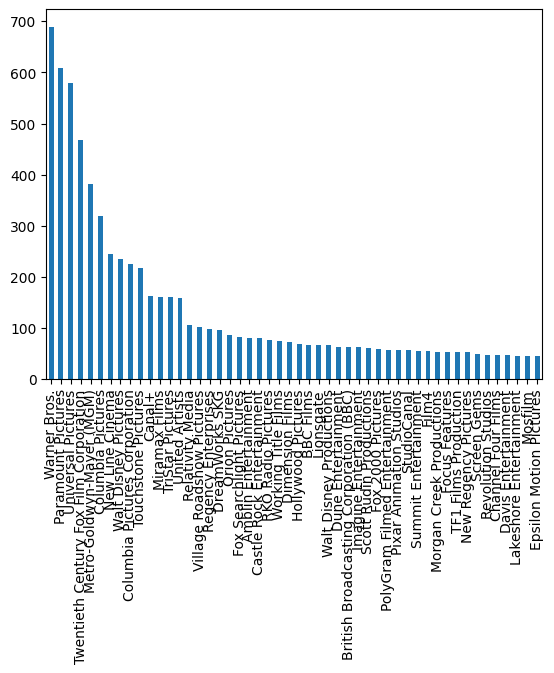

In [32]:
movies['production_companies'].apply(lambda x: [o['name'] for o in x]).explode().value_counts()[:50].plot(kind='bar')

In [33]:
production_companies = movies['production_companies'].apply(
    lambda x: [o['name'] for o in x]).explode().value_counts().sort_values(ascending=False)
production_companies

Warner Bros.                              689
Paramount Pictures                        608
Universal Pictures                        580
Twentieth Century Fox Film Corporation    467
Metro-Goldwyn-Mayer (MGM)                 382
                                         ... 
Brucks Entertainment                        1
Renovatio Entertainment                     1
Oxymoron Entertainment                      1
Mallick Media                               1
LOLflix                                     1
Name: production_companies, Length: 8620, dtype: int64

In [34]:
for company in production_companies.sort_values(ascending=False).index[:50]:
    movies[company] = movies['production_companies'].apply(lambda x: company in [o['name'] for o in x]).astype(int)

for company in production_companies.sort_values(ascending=False).index[50:]:
    movies['other_company'] = movies['production_companies'].apply(lambda x: company in [o['name'] for o in x]).astype(
        int)

movies

,movieId,title,genres,title_name,title_name_tokens,title_mapped,Adventure,Animation,Children,Comedy,...,TF1 Films Production,New Regency Pictures,Screen Gems,Revolution Studios,Channel Four Films,Davis Entertainment,Lakeshore Entertainment,Mosfilm,Epsilon Motion Pictures,other_company
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,"{'story', 'toy'}",Toy Story,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,{'jumanji'},Jumanji,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,"{'grumpier', 'men', 'old'}",Grumpier Old Men,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,"{'to', 'exhale', 'waiting'}",Waiting to Exhale,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,"{'of', 'bride', 'ii', 'part', 'father'}",Father of the Bride Part II,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,No Game No Life: Zero,"{'game', 'no', 'zero', 'life'}",The Game,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),Drama,Flint,{'flint'},In Like Flint,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple,"{'apple', 'dead', 'dogs', 'bungo', 'stray'}",Stray Dogs,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple,"{'apple', 'dead', 'dogs', 'bungo', 'stray'}",Stray Dogs,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train Test Split

In [35]:
def even_train_test_split(data, random_state=42):
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

    for user in data['userId'].unique():
        X = data[data['userId'] == user]
        X_train, X_test = train_test_split(X, test_size=0.5, random_state=random_state)

        train_df = pd.concat([train_df, X_train], axis=0, ignore_index=True)
        test_df = pd.concat([test_df, X_test], axis=0, ignore_index=True)

    return train_df, test_df

In [36]:
def ratings_train_test_split(data, random_state=42):
    train_df, test_df = even_train_test_split(data, random_state=random_state)

    movies_ids = data['movieId'].unique()

    # make sure that all of the movies are present in both test and train (otherwise we won't be able to create a matrix)
    for movie in movies_ids:
        if movie not in train_df['movieId'].values:
            train_df = train_df.append(pd.Series({'userId': 1, 'movieId': movie, 'rating': pd.NA}), ignore_index=True)
        if movie not in test_df['movieId'].values:
            test_df = test_df.append(pd.Series({'userId': 1, 'movieId': movie, 'rating': pd.NA}), ignore_index=True)
    return train_df, test_df

In [37]:
train_ratings, test_ratings = ratings_train_test_split(ratings)
train_ratings

/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_4216/2616134969.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(pd.Series({'userId': 1, 'movieId': movie, 'rating': pd.NA}), ignore_index=True)
/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_4216/2616134969.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(pd.Series({'userId': 1, 'movieId': movie, 'rating': pd.NA}), ignore_index=True)
/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_4216/2616134969.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(pd.Series({'userId': 1, 'movieId': movie, 'rating': pd.NA}), ignore_index=True)
/var/folders/tn/_r_b9n8d0bg1fzccs

,userId,movieId,rating,timestamp
0,1,3439,4.0,964981799.0
1,1,2858,5.0,964980868.0
2,1,592,4.0,964982271.0
3,1,216,5.0,964981208.0
4,1,3740,4.0,964982417.0
...,...,...,...,...
52401,1,146309,NaN,NaN
52402,1,148166,NaN,NaN
52403,1,149011,NaN,NaN
52404,1,152372,NaN,NaN


In [38]:
train_ratings.to_csv('data/train_ratings.csv', index=False)
test_ratings.to_csv('data/test_ratings.csv', index=False)

In [39]:
average_ratings = train_ratings[['movieId', 'rating']].groupby('movieId').mean()
average_ratings

,rating
movieId,
1,4.066667
2,3.395062
3,3.478261
4,2.666667
5,3.102941
...,...
193581,4.000000
193583,3.500000
193585,NaN


In [40]:
reader = Reader(rating_scale=(1, 5))

train_data_mf = Dataset.load_from_df(train_ratings[['userId', 'movieId', 'rating']].fillna(0.0), reader)
test_data_mf = Dataset.load_from_df(test_ratings[['userId', 'movieId', 'rating']].fillna(0.0), reader)

svd_train_set = train_data_mf.build_full_trainset()
svd_test_set = test_data_mf.build_full_trainset()

In [41]:
svd = SVD(n_factors=100, biased=True, random_state=42, verbose=True, n_epochs=25)
svd.fit(svd_train_set)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24


In [42]:
train_rating_preds = svd.test(svd_train_set.build_testset())

print('Train RMSE:', surprise.accuracy.rmse(train_rating_preds))
print('Train MAE:', surprise.accuracy.mae(train_rating_preds))

train_pred_mf = np.array([pred.est for pred in train_rating_preds])
train_pred_mf

RMSE: 0.6128
Train RMSE: 0.6128093879066491
MAE:  0.4752
Train MAE: 0.4751758325703684


array([1.35971834, 2.22073631, 1.        , ..., 3.35064381, 4.28019402,
       4.17916197])

In [43]:
test_rating_preds = svd.test(svd_test_set.build_testset())

print('Test RMSE:', surprise.accuracy.rmse(test_rating_preds))
print('Test MAE:', surprise.accuracy.mae(test_rating_preds))

test_pred_mf = np.array([pred.est for pred in test_rating_preds])
test_pred_mf

RMSE: 0.9098
Test RMSE: 0.9098063736855437
MAE:  0.7064
Test MAE: 0.7064036231827042


array([1.        , 1.        , 1.        , ..., 3.32615074, 3.65986986,
       3.09144121])

In [44]:
users_sim = svd.compute_similarities()

Computing the msd similarity matrix...
Done computing similarity matrix.


In [45]:
# find ratings for the movies for top 5 cosine similar users

def get_top_similar_users(user_id, users_sim, top_n=5):
    user_similarities = users_sim[user_id - 1]

    top_similar_users = np.argsort(user_similarities)[-top_n:]

    return top_similar_users


def get_similar_users_ratings(user_id, movie_id, users_sim, svd, top_n=5):
    similar_users = get_top_similar_users(user_id, users_sim, top_n)

    similar_users_ratings = [svd.predict(user, movie_id).est for user in similar_users]

    return similar_users_ratings

In [46]:
get_similar_users_ratings(1, 314, users_sim, svd, 5)

[3.688819535067983,
 4.065865000233481,
 3.5950106271212308,
 3.278197423647855,
 3.711255579275959]

## Content Based Filtering

In [47]:
movies = movies.join(average_ratings.rename({'rating': 'avg_rating'}, axis=1), on='movieId')
movies

,movieId,title,genres,title_name,title_name_tokens,title_mapped,Adventure,Animation,Children,Comedy,...,New Regency Pictures,Screen Gems,Revolution Studios,Channel Four Films,Davis Entertainment,Lakeshore Entertainment,Mosfilm,Epsilon Motion Pictures,other_company,avg_rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,"{'story', 'toy'}",Toy Story,1,1,1,1,...,0,0,0,0,0,0,0,0,0,4.066667
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,{'jumanji'},Jumanji,1,0,1,0,...,0,0,0,0,0,0,0,0,0,3.395062
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,"{'grumpier', 'men', 'old'}",Grumpier Old Men,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.478261
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,"{'to', 'exhale', 'waiting'}",Waiting to Exhale,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.666667
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,"{'of', 'bride', 'ii', 'part', 'father'}",Father of the Bride Part II,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.102941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,No Game No Life: Zero,"{'game', 'no', 'zero', 'life'}",The Game,0,1,0,1,...,0,0,0,0,0,0,0,0,0,3.500000
9739,193585,Flint (2017),Drama,Flint,{'flint'},In Like Flint,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple,"{'apple', 'dead', 'dogs', 'bungo', 'stray'}",Stray Dogs,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.500000
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple,"{'apple', 'dead', 'dogs', 'bungo', 'stray'}",Stray Dogs,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.500000


In [48]:
movies = movies.drop_duplicates(subset=['movieId'])
movies

,movieId,title,genres,title_name,title_name_tokens,title_mapped,Adventure,Animation,Children,Comedy,...,New Regency Pictures,Screen Gems,Revolution Studios,Channel Four Films,Davis Entertainment,Lakeshore Entertainment,Mosfilm,Epsilon Motion Pictures,other_company,avg_rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,"{'story', 'toy'}",Toy Story,1,1,1,1,...,0,0,0,0,0,0,0,0,0,4.066667
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,{'jumanji'},Jumanji,1,0,1,0,...,0,0,0,0,0,0,0,0,0,3.395062
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,"{'grumpier', 'men', 'old'}",Grumpier Old Men,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.478261
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,"{'to', 'exhale', 'waiting'}",Waiting to Exhale,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.666667
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,"{'of', 'bride', 'ii', 'part', 'father'}",Father of the Bride Part II,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3.102941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,Black Butler: Book of the Atlantic,"{'of', 'butler', 'atlantic', 'black', 'book'}",Black Book,0,1,0,1,...,0,0,0,0,0,0,0,0,0,4.000000
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,No Game No Life: Zero,"{'game', 'no', 'zero', 'life'}",The Game,0,1,0,1,...,0,0,0,0,0,0,0,0,0,3.500000
9739,193585,Flint (2017),Drama,Flint,{'flint'},In Like Flint,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple,"{'apple', 'dead', 'dogs', 'bungo', 'stray'}",Stray Dogs,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.500000


In [49]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 0 to 9741
Data columns (total 86 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   movieId                                 9742 non-null   int64  
 1   title                                   9742 non-null   object 
 2   genres                                  9742 non-null   object 
 3   title_name                              9742 non-null   object 
 4   title_name_tokens                       9742 non-null   object 
 5   title_mapped                            9742 non-null   object 
 6   Adventure                               9742 non-null   int64  
 7   Animation                               9742 non-null   int64  
 8   Children                                9742 non-null   int64  
 9   Comedy                                  9742 non-null   int64  
 10  Fantasy                                 9742 non-null   int6

In [50]:
movies['overview'] = movies['overview'].fillna('')

/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_4216/2373819262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['overview'] = movies['overview'].fillna('')


In [51]:
lemmatizer = WordNetLemmatizer()

In [52]:
# remove punctuation from overview and make it lowercase and lemmatize

def clean_overview(overview):
    overview = overview.lower()
    overview = overview.translate(str.maketrans('', '', string.punctuation))
    overview = ' '.join([lemmatizer.lemmatize(word) for word in overview.split()])
    return overview


movies['overview'] = movies['overview'].apply(clean_overview)

/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_4216/2954538774.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['overview'] = movies['overview'].apply(clean_overview)


In [66]:
def clean_data(data):
    data['overview'] = data['overview'].fillna('')
    data['overview'] = data['overview'].apply(clean_overview)
    data['budget'] = pd.to_numeric(data['budget']).fillna(0)
    data['popularity'] = pd.to_numeric(data['popularity']).fillna(0)
    data['runtime'] = data['runtime'].fillna(0)
    data['avg_rating'] = data['avg_rating'].fillna(0)

    if 'userId' in data.columns:
        data['userId'] = data['userId'].astype(int)

    if 'rating' in data.columns:
        return data.dropna(subset=['rating'])
    return data

In [54]:
user_movies = movies.join(ratings.set_index('movieId')[['userId', 'rating']], on=['movieId'], how='left')
user_movies

,movieId,title,genres,title_name,title_name_tokens,title_mapped,Adventure,Animation,Children,Comedy,...,Revolution Studios,Channel Four Films,Davis Entertainment,Lakeshore Entertainment,Mosfilm,Epsilon Motion Pictures,other_company,avg_rating,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,"{'story', 'toy'}",Toy Story,1,1,1,1,...,0,0,0,0,0,0,0,4.066667,1.0,4.0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,"{'story', 'toy'}",Toy Story,1,1,1,1,...,0,0,0,0,0,0,0,4.066667,5.0,4.0
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,"{'story', 'toy'}",Toy Story,1,1,1,1,...,0,0,0,0,0,0,0,4.066667,7.0,4.5
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,"{'story', 'toy'}",Toy Story,1,1,1,1,...,0,0,0,0,0,0,0,4.066667,15.0,2.5
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,"{'story', 'toy'}",Toy Story,1,1,1,1,...,0,0,0,0,0,0,0,4.066667,17.0,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,Black Butler: Book of the Atlantic,"{'of', 'butler', 'atlantic', 'black', 'book'}",Black Book,0,1,0,1,...,0,0,0,0,0,0,0,4.000000,184.0,4.0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,No Game No Life: Zero,"{'game', 'no', 'zero', 'life'}",The Game,0,1,0,1,...,0,0,0,0,0,0,0,3.500000,184.0,3.5
9739,193585,Flint (2017),Drama,Flint,{'flint'},In Like Flint,0,0,0,0,...,0,0,0,0,0,0,0,NaN,184.0,3.5
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,Bungo Stray Dogs: Dead Apple,"{'apple', 'dead', 'dogs', 'bungo', 'stray'}",Stray Dogs,0,1,0,0,...,0,0,0,0,0,0,0,3.500000,184.0,3.5


In [67]:
user_movies = clean_data(user_movies)
movies = clean_data(movies)

/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_4216/39570587.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['overview'] = data['overview'].fillna('')
/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_4216/39570587.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['overview'] = data['overview'].apply(clean_overview)
/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_4216/39570587.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [94]:
# movies = movies.drop(columns=['title', 'genres', 'production_companies', 'title_name', 'title_name_tokens', 'title_mapped', 'overview'])
movies.to_csv('data/movies_cleaned.csv', index=False)

In [69]:
train_movies, test_movies = even_train_test_split(user_movies)
train_movies

,movieId,title,genres,title_name,title_name_tokens,title_mapped,Adventure,Animation,Children,Comedy,...,Revolution Studios,Channel Four Films,Davis Entertainment,Lakeshore Entertainment,Mosfilm,Epsilon Motion Pictures,other_company,avg_rating,userId,rating
0,3439,Teenage Mutant Ninja Turtles II: The Secret of...,Action|Children|Fantasy,Teenage Mutant Ninja Turtles II: The Secret of...,"{'of', 'ii', 'mutant', 'secret', 'teenage', 't...",Teenage Mutant Ninja Turtles II: The Secret of...,0,0,1,0,...,0,0,0,0,0,0,0,2.833333,1,4.0
1,2858,American Beauty (1999),Drama|Romance,American Beauty,"{'american', 'beauty'}",American Beauty,0,0,0,0,...,0,0,0,0,0,0,0,4.037037,1,5.0
2,592,Batman (1989),Action|Crime|Thriller,Batman,{'batman'},Batman,0,0,0,0,...,0,0,0,0,0,0,0,3.467290,1,4.0
3,216,Billy Madison (1995),Comedy,Billy Madison,"{'billy', 'madison'}",Billy Madison,0,0,0,1,...,0,0,0,0,0,0,0,3.184211,1,5.0
4,3740,Big Trouble in Little China (1986),Action|Adventure|Comedy|Fantasy,Big Trouble in Little China,"{'trouble', 'big', 'little', 'china', 'in'}",Big Trouble in Little China,1,0,0,1,...,0,0,0,0,0,0,0,3.769231,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50265,122926,Untitled Spider-Man Reboot (2017),Action|Adventure|Fantasy,Untitled Spider-Man Reboot,"{'reboot', 'spiderman', 'untitled'}",Spider-Man,1,0,0,0,...,0,0,0,0,0,0,0,4.375000,184,4.0
50266,175475,The Emoji Movie (2017),Animation|Children|Comedy,The Emoji Movie,"{'movie', 'emoji'}",The Emoji Movie,0,1,1,1,...,0,0,0,0,0,0,0,0.500000,184,0.5
50267,48780,"Prestige, The (2006)",Drama|Mystery|Sci-Fi|Thriller,"Prestige, The",{'prestige'},The Prestige,0,0,0,0,...,0,0,0,0,0,0,0,4.017241,184,5.0
50268,165635,The Thinning (2016),Thriller,The Thinning,{'thinning'},The Thinning,0,0,0,0,...,0,0,0,0,0,0,0,1.000000,184,1.0


In [70]:
def rank_data(data, users_sim, svd, top_n=5):
    for i in range(5):
        data[f'su_{i}'] = 0.0
    data['svd_rating'] = 0.0

    for i, (userId, movieId) in enumerate(data[['userId', 'movieId']].values):
        data.iat[i, data.columns.get_loc('svd_rating')] = svd.predict(int(userId), int(movieId)).est
        similar_ratings = get_similar_users_ratings(userId, movieId, users_sim, svd, top_n)

        for uid, r in enumerate(similar_ratings):
            data.iat[i, data.columns.get_loc(f'su_{uid}')] = r
    return data

In [71]:
train_movies = rank_data(train_movies, users_sim, svd, 5)

In [72]:
test_movies = rank_data(test_movies, users_sim, svd, 5)

In [75]:
X_train, y_train = train_movies.drop(columns=[
    'title',
    'userId',
    'movieId',
    'rating',
    'genres',
    'title_name',
    'title_name_tokens',
    'title_mapped',
    'overview',
    'production_companies',
]), train_movies['rating']

X_train

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,...,Mosfilm,Epsilon Motion Pictures,other_company,avg_rating,su_0,su_1,su_2,su_3,su_4,svd_rating
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,2.833333,3.614819,3.437622,3.174206,3.146623,3.415193,1.359718
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,4.037037,4.083308,4.054747,4.065579,3.806017,3.970887,2.220736
2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,3.467290,3.613615,3.849265,2.986759,3.359336,3.422988,1.000000
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,3.184211,3.658734,3.552786,3.174505,3.124947,3.407450,1.471803
4,1,0,0,1,1,0,0,1,0,0,...,0,0,0,3.769231,4.246527,4.364161,3.924315,3.709544,3.956563,1.629068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50265,1,0,0,0,1,0,0,1,0,0,...,0,0,0,4.375000,4.008069,3.915537,4.153530,3.873934,4.119668,4.119668
50266,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0.500000,3.470413,3.251066,3.456531,3.205784,2.529040,2.529040
50267,0,0,0,0,0,0,1,0,0,1,...,0,0,0,4.017241,4.064559,4.207689,4.462110,3.961247,4.228168,4.228168
50268,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1.000000,3.474332,3.165574,3.579331,3.243792,2.709536,2.709536


In [76]:
X_test, y_test = test_movies.drop(columns=[
    'title',
    # 'userId',
    # 'movieId',
    'rating',
    'genres',
    'title_name',
    'title_name_tokens',
    'title_mapped',
    'overview',
    'production_companies',
]), test_movies['rating']

In [78]:
config = {
    'random_state': 42
}

In [87]:
ada = AdaBoostRegressor(**config)
ada.fit(X_train, y_train)

AdaBoostRegressor(random_state=42)

In [88]:
test_pred = ada.predict(X_test.drop(columns=['movieId', 'userId']))
mean_squared_error(y_test, test_pred, squared=False), mean_absolute_error(y_test, test_pred)

(0.9225582577314624, 0.7143498162644162)

In [89]:
def predict(user_id, movies, users_sim, model, svd, top_n=5):
    data = movies.copy()
    for i in range(5):
        data[f'su_{i}'] = 0.0
    data['svd_rating'] = 0.0

    for i, movieId in enumerate(movies['movieId'].values):
        data.iat[i, data.columns.get_loc('svd_rating')] = svd.predict(int(user_id), int(movieId)).est
        similar_ratings = get_similar_users_ratings(user_id, movieId, users_sim, svd, top_n)

        for uid, r in enumerate(similar_ratings):
            data.iat[i, data.columns.get_loc(f'su_{uid}')] = r

    prediction = model.predict(data.drop(columns=['movieId']))
    return data.iloc[np.argsort(prediction)[-top_n:], :], prediction[np.argsort(prediction)[-top_n:]]

In [92]:
predict(1, movies.drop_duplicates(subset=['movieId']), users_sim, ada, svd, 5)

(      movieId  Adventure  Animation  Children  Comedy  Fantasy  Romance  \
 1370     1875          0          0         0       1        0        0   
 1928     2557          0          0         0       0        0        0   
 7722    90439          0          0         0       0        0        0   
 9559   173317          0          0         0       0        0        0   
 5448    26073          0          0         0       0        0        0   
 
       Drama  Action  Crime  ...  Mosfilm  Epsilon Motion Pictures  \
 1370      0       0      0  ...        0                        0   
 1928      1       0      0  ...        0                        0   
 7722      1       0      0  ...        0                        0   
 9559      0       0      0  ...        0                        0   
 5448      1       0      0  ...        0                        0   
 
       other_company  avg_rating      su_0      su_1      su_2      su_3  \
 1370              0        4.25  3.901476  

What do I need to make a prediction:

- User ID
- Model to predict similar users ratings
- Test set of movies to evaluate rank the user against (rate the user against all of the movies in the test set, and predict the score)
- Model to predict the rating of the movie (lightboost)
- If the movie is in the top 5, and is in the test list - measure the prediction error

In [93]:
dump(ada, 'models/ada.joblib')
dump(svd, 'models/svd.joblib')

['models/svd.joblib']

In [ ]:
movies